Note:

Forget “perplexity”.
For domain SLMs, you want to track:

Metric	Description
Exact match rate	% of tokens matching valid domain grammar
Parse accuracy	% of generated outputs that compile/execute
Semantic validity	% of outputs that make logical sense
Entropy per token	How confident vs overfitted model is

In [1]:
from datasets import load_dataset

d:\tech-garage\Deep-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("YvvonM/mental_health_data")
train_dataset = dataset['train'].train_test_split(test_size=0.1)['train']
eval_dataset = dataset['train'].train_test_split(test_size=0.1)['test']

In [3]:
train_batch_size = 8  # training batch size
eval_batch_size = 4  # evaluation batch size
context_length = block_size = 126  # number of tokens processed in a single batch
train_split = 0.9  # percentage of data to use from total data for training
number_of_heads = 8
number_of_layers = 6

In [4]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast(
    tokenizer_file="../slm/tokenizer.json",
    truncation=True,
    unk_token="<UNK>",
    pad_token="<PAD>",
    bos_token="<BOS>",
    eos_token="<EOS>",
    max_length=context_length
)

In [5]:

def tokenize_and_shift_labels(example):
    text = f"<BOS> <USER> {example['Input']} <ASSISTANT> {example['Response']} <EOS>"
    encoding = tokenizer(
        text,
        truncation=True,
        max_length=context_length,
        padding='max_length'
    )
    input_ids = encoding["input_ids"]

    inputs = input_ids[:-1]
    labels = input_ids[1:]
    labels = [l if l != tokenizer.pad_token_id else -100 for l in labels]

    return {"input_ids": inputs, "labels": labels}

In [6]:
train_dataset = train_dataset.map(
    tokenize_and_shift_labels,
    remove_columns=train_dataset.column_names,
)

eval_dataset = eval_dataset.map(
    tokenize_and_shift_labels,
    remove_columns=eval_dataset.column_names,
)

Map: 100%|██████████| 176279/176279 [03:10<00:00, 923.11 examples/s]


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cpu"

if torch.cuda.is_available():
  device = "cuda"

In [8]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # causal LM
)

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)


In [16]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, context_length, d_model):
        super().__init__()
        self.register_buffer("pe", self._build_pe(context_length, d_model))
        self.dropout = nn.Dropout(0.1)



    def _build_pe(self, length, d_model):
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(length, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # shape: [1, length, d_model]

    def forward(self, x):
        seq_len = x.size(1)
        return self.dropout(x + self.pe[:, :seq_len, :])


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.fc_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape
        qkv = self.qkv_proj(x)
        q, k, v = qkv.chunk(3, dim=-1)

        # Reshape for heads
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float("-inf"))
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = attn_weights @ v

        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        return self.fc_out(self.dropout(attn_output))

In [12]:
class GPTBlock(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask):
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.mlp(self.ln2(x))
        return x


In [17]:
class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, context_length, dropout=0.1):
        super().__init__()
        self.context_length = context_length
        self.wte = nn.Embedding(vocab_size, d_model)
        self.wpe = PositionalEncoding(context_length, d_model)

        self.blocks = nn.ModuleList([
            GPTBlock(d_model, n_heads, dropout) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.wte.weight  # Weight tying

        nn.init.normal_(self.wte.weight, mean=0.0, std=0.02)


    def forward(self, x, targets=None):
        B, T = x.size()
        assert T <= self.context_length, f"Input length {T} exceeds context length {self.context_length}"

        mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)
        x = self.wte(x)
        x = self.wpe(x)

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.lm_head(x)  # [B, T, vocab_size]

        loss = None
        if targets is not None:
            # Trim targets/logits to same length
            min_len = min(logits.size(1), targets.size(1))
            logits = logits[:, :min_len, :]
            targets = targets[:, :min_len]

            # Flatten for cross-entropy
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1),
                ignore_index=-100,
                label_smoothing=0.1
            )

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, top_k=50, top_p=0.9, temperature=1.0, repetition_penalty=1.1):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.context_length:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Repetition penalty
            for i in range(idx.size(0)):
                for token in idx[i].tolist():
                    logits[i, token] /= repetition_penalty

            # Top-k
            if top_k is not None:
                values, _ = torch.topk(logits, top_k)
                min_values = values[:, -1].unsqueeze(1)
                logits = torch.where(logits < min_values, float("-inf"), logits)

            # Top-p
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                probs = F.softmax(sorted_logits, dim=-1)
                cumulative_probs = torch.cumsum(probs, dim=-1)
                sorted_mask = cumulative_probs > top_p
                sorted_mask[:, 1:] = sorted_mask[:, :-1].clone()
                sorted_mask[:, 0] = 0
                logits.scatter_(1, sorted_indices, logits.masked_fill(sorted_mask, float("-inf")))

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx


In [18]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
train_batch_size = 16
eval_batch_size = 8
eval_steps = 2000
log_interval = 10  # log every n steps
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)


In [19]:
basic_model = GPT(vocab_size=8000, d_model=256, n_heads=number_of_heads, n_layers=number_of_layers, context_length=context_length).to(device)
# basic_model = GPT(vocab_size=8000, d_model=256).to(device)




basic_model.to(device)
optimizer = torch.optim.AdamW(basic_model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*len(train_loader))


In [20]:
print(basic_model)
print(f"Total Parameters: {round(sum(p.numel() for p in basic_model.parameters() if p.requires_grad) / 1_000_000)}M")

GPT(
  (wte): Embedding(8000, 256)
  (wpe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blocks): ModuleList(
    (0-5): 6 x GPTBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv_proj): Linear(in_features=256, out_features=768, bias=True)
        (fc_out): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=8000, bias=False)
)
Total Parameters: 7M


In [21]:
xb = next(iter(train_loader))
xb_ids = xb['input_ids'].to(device)
x_embed = basic_model.wte(xb_ids)
print("Embedding stats:", x_embed.min().item(), x_embed.max().item(), x_embed.mean().item())

Embedding stats: -0.08437272161245346 0.08929158002138138 0.00020324299111962318


In [22]:
x_pos = basic_model.wpe(x_embed)
print("After positional encoding:", x_pos.min().item(), x_pos.max().item(), x_pos.mean().item())


After positional encoding: -1.191179633140564 1.2028255462646484 0.3441179096698761


In [23]:
mask = torch.tril(torch.ones(xb_ids.size(1), xb_ids.size(1), device=device)).unsqueeze(0).unsqueeze(0)
x = x_embed + x_pos

for i, block in enumerate(basic_model.blocks):
    x = block(x, mask)
    print(f"After block {i}: min={x.min().item()}, max={x.max().item()}, mean={x.mean().item()}")


After block 0: min=-2.3138678073883057, max=2.4102468490600586, mean=0.3375180959701538
After block 1: min=-2.750420331954956, max=3.241375207901001, mean=0.31798237562179565
After block 2: min=-3.4768643379211426, max=4.115438938140869, mean=0.32602840662002563
After block 3: min=-3.774178981781006, max=3.7600839138031006, mean=0.30100536346435547
After block 4: min=-4.057812690734863, max=4.06535005569458, mean=0.29670557379722595
After block 5: min=-4.162103176116943, max=4.711940765380859, mean=0.2674368917942047


In [24]:
x_ln = basic_model.ln_f(x)
logits = basic_model.lm_head(x_ln)
print("Final logits stats:", logits.min().item(), logits.max().item(), logits.mean().item())


Final logits stats: -1.5007562637329102 1.6736133098602295 0.0029576916713267565


In [25]:

logits, loss = basic_model(xb['input_ids'].to(device), xb['labels'].to(device))
print(logits.shape, loss.item())

torch.Size([16, 125, 8000]) 8.982916831970215


In [27]:
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

scaler = GradScaler()
accum_steps = 4
eval_subset = 100
log_interval = 50000

train_losses, eval_losses = [], []

for epoch in range(epochs):
    basic_model.train()
    running_loss = 0.0
    step_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for step, batch in enumerate(step_bar):
        xb = batch['input_ids'].to(device, non_blocking=True)
        yb = batch['labels'].to(device, non_blocking=True)

        with autocast():
            logits, loss = basic_model(xb, yb)
            loss = loss / accum_steps

        scaler.scale(loss).backward()
        running_loss += loss.item()

        if (step + 1) % accum_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(basic_model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        # Show loss in progress bar occasionally
        if (step + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            step_bar.set_postfix(train_loss=f"{avg_loss:.4f}")
            train_losses.append(avg_loss)
            running_loss = 0.0

        # Evaluate periodically
        if (step + 1) % eval_steps == 0:
            basic_model.eval()
            eval_loss = 0.0
            with torch.no_grad():
                for eval_step, eval_batch in enumerate(eval_loader):
                    if eval_step >= eval_subset:
                        break
                    xvb = eval_batch['input_ids'].to(device, non_blocking=True)
                    yvb = eval_batch['labels'].to(device, non_blocking=True)
                    with autocast():
                        _, e_loss = basic_model(xvb, yvb)
                    eval_loss += e_loss.item()
            eval_loss /= eval_subset
            tqdm.write(f"[Eval] Epoch {epoch+1}, Step {step+1}: Loss = {eval_loss:.4f}")
            eval_losses.append(eval_loss)
            basic_model.train()

    # Save checkpoint at the end of epoch
    checkpoint_path = os.path.join(save_dir, f"slm_epoch_{epoch+1}.pt")
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': basic_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'eval_losses': eval_losses
    }, checkpoint_path)
    tqdm.write(f"Checkpoint saved at {checkpoint_path}")


C:\Users\dipgh\AppData\Local\Temp\ipykernel_19324\1831597649.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/99157 [00:00<?, ?it/s]C:\Users\dipgh\AppData\Local\Temp\ipykernel_19324\1831597649.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10:   2%|▏         | 1998/99157 [01:32<1:21:23, 19.90it/s]C:\Users\dipgh\AppData\Local\Temp\ipykernel_19324\1831597649.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10:   2%|▏         | 2001/99157 [01:34<6:26:10,  4.19it/s]

[Eval] Epoch 1, Step 2000: Loss = 1.4373


Epoch 1/10:   4%|▍         | 4002/99157 [03:11<5:05:33,  5.19it/s]

[Eval] Epoch 1, Step 4000: Loss = 1.3081


Epoch 1/10:   6%|▌         | 6003/99157 [04:52<4:11:49,  6.17it/s]

[Eval] Epoch 1, Step 6000: Loss = 1.2797


Epoch 1/10:   8%|▊         | 8004/99157 [06:46<5:03:10,  5.01it/s]

[Eval] Epoch 1, Step 8000: Loss = 1.2603


Epoch 1/10:  10%|█         | 10002/99157 [08:43<5:17:28,  4.68it/s]

[Eval] Epoch 1, Step 10000: Loss = 1.2566


Epoch 1/10:  12%|█▏        | 12001/99157 [10:44<7:18:50,  3.31it/s]

[Eval] Epoch 1, Step 12000: Loss = 1.2519


Epoch 1/10:  14%|█▍        | 14003/99157 [12:39<4:56:14,  4.79it/s]

[Eval] Epoch 1, Step 14000: Loss = 1.2478


Epoch 1/10:  16%|█▌        | 16004/99157 [14:45<4:54:30,  4.71it/s]

[Eval] Epoch 1, Step 16000: Loss = 1.2449


Epoch 1/10:  18%|█▊        | 18003/99157 [16:56<4:44:11,  4.76it/s]

[Eval] Epoch 1, Step 18000: Loss = 1.2442


Epoch 1/10:  20%|██        | 20004/99157 [19:03<4:35:19,  4.79it/s]

[Eval] Epoch 1, Step 20000: Loss = 1.2432


Epoch 1/10:  22%|██▏       | 22004/99157 [21:10<4:13:16,  5.08it/s]

[Eval] Epoch 1, Step 22000: Loss = 1.2420


Epoch 1/10:  24%|██▍       | 24004/99157 [23:16<4:12:54,  4.95it/s]

[Eval] Epoch 1, Step 24000: Loss = 1.2422


Epoch 1/10:  26%|██▌       | 26003/99157 [25:20<4:19:07,  4.71it/s]

[Eval] Epoch 1, Step 26000: Loss = 1.2416


Epoch 1/10:  28%|██▊       | 28003/99157 [27:24<3:20:26,  5.92it/s]

[Eval] Epoch 1, Step 28000: Loss = 1.2421


Epoch 1/10:  30%|███       | 30004/99157 [29:28<3:50:57,  4.99it/s]

[Eval] Epoch 1, Step 30000: Loss = 1.2372


Epoch 1/10:  32%|███▏      | 32003/99157 [31:35<3:44:24,  4.99it/s]

[Eval] Epoch 1, Step 32000: Loss = 1.2435


Epoch 1/10:  34%|███▍      | 34001/99157 [33:40<6:48:07,  2.66it/s]

[Eval] Epoch 1, Step 34000: Loss = 1.2385


Epoch 1/10:  36%|███▋      | 36004/99157 [35:51<4:18:39,  4.07it/s]

[Eval] Epoch 1, Step 36000: Loss = 1.2377


Epoch 1/10:  38%|███▊      | 38003/99157 [38:02<3:32:35,  4.79it/s]

[Eval] Epoch 1, Step 38000: Loss = 1.2375


Epoch 1/10:  40%|████      | 40003/99157 [40:07<3:10:45,  5.17it/s]

[Eval] Epoch 1, Step 40000: Loss = 1.2361


Epoch 1/10:  42%|████▏     | 42003/99157 [42:14<3:14:26,  4.90it/s]

[Eval] Epoch 1, Step 42000: Loss = 1.2360


Epoch 1/10:  44%|████▍     | 44003/99157 [44:24<3:10:13,  4.83it/s]

[Eval] Epoch 1, Step 44000: Loss = 1.2355


Epoch 1/10:  46%|████▋     | 46004/99157 [46:30<3:00:38,  4.90it/s]

[Eval] Epoch 1, Step 46000: Loss = 1.2358


Epoch 1/10:  48%|████▊     | 48004/99157 [48:40<3:03:56,  4.63it/s]

[Eval] Epoch 1, Step 48000: Loss = 1.2360


Epoch 1/10:  50%|█████     | 50004/99157 [50:54<2:42:03,  5.05it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 50000: Loss = 1.2352


Epoch 1/10:  52%|█████▏    | 52003/99157 [52:59<2:41:46,  4.86it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 52000: Loss = 1.2348


Epoch 1/10:  54%|█████▍    | 54004/99157 [55:05<2:32:02,  4.95it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 54000: Loss = 1.2347


Epoch 1/10:  56%|█████▋    | 56004/99157 [57:12<2:21:43,  5.07it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 56000: Loss = 1.2352


Epoch 1/10:  58%|█████▊    | 58003/99157 [59:11<2:25:50,  4.70it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 58000: Loss = 1.2338


Epoch 1/10:  61%|██████    | 60004/99157 [1:01:05<2:08:28,  5.08it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 60000: Loss = 1.2346


Epoch 1/10:  63%|██████▎   | 62003/99157 [1:02:57<2:01:08,  5.11it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 62000: Loss = 1.2347


Epoch 1/10:  65%|██████▍   | 64003/99157 [1:04:50<2:01:51,  4.81it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 64000: Loss = 1.2348


Epoch 1/10:  67%|██████▋   | 66004/99157 [1:06:49<1:49:52,  5.03it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 66000: Loss = 1.2339


Epoch 1/10:  69%|██████▊   | 68004/99157 [1:08:47<1:39:38,  5.21it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 68000: Loss = 1.2333


Epoch 1/10:  71%|███████   | 70003/99157 [1:10:43<1:30:37,  5.36it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 70000: Loss = 1.2338


Epoch 1/10:  73%|███████▎  | 72004/99157 [1:12:36<1:20:14,  5.64it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 72000: Loss = 1.2350


Epoch 1/10:  75%|███████▍  | 74003/99157 [1:14:33<1:21:03,  5.17it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 74000: Loss = 1.2338


Epoch 1/10:  77%|███████▋  | 76003/99157 [1:16:26<1:14:55,  5.15it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 76000: Loss = 1.2331


Epoch 1/10:  79%|███████▊  | 78003/99157 [1:18:15<1:04:12,  5.49it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 78000: Loss = 1.2326


Epoch 1/10:  81%|████████  | 80004/99157 [1:20:04<1:05:21,  4.88it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 80000: Loss = 1.2331


Epoch 1/10:  83%|████████▎ | 82004/99157 [1:21:56<58:56,  4.85it/s, train_loss=0.3206]  

[Eval] Epoch 1, Step 82000: Loss = 1.2333


Epoch 1/10:  85%|████████▍ | 84002/99157 [1:23:54<1:12:17,  3.49it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 84000: Loss = 1.2339


Epoch 1/10:  87%|████████▋ | 86003/99157 [1:25:52<39:56,  5.49it/s, train_loss=0.3206]  

[Eval] Epoch 1, Step 86000: Loss = 1.2329


Epoch 1/10:  89%|████████▉ | 88003/99157 [1:27:52<44:53,  4.14it/s, train_loss=0.3206]  

[Eval] Epoch 1, Step 88000: Loss = 1.2326


Epoch 1/10:  91%|█████████ | 90003/99157 [1:29:46<33:19,  4.58it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 90000: Loss = 1.2327


Epoch 1/10:  93%|█████████▎| 92003/99157 [1:31:44<23:33,  5.06it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 92000: Loss = 1.2324


Epoch 1/10:  95%|█████████▍| 94001/99157 [1:33:40<24:07,  3.56it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 94000: Loss = 1.2330


Epoch 1/10:  97%|█████████▋| 96004/99157 [1:35:29<09:21,  5.61it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 96000: Loss = 1.2327


Epoch 1/10:  99%|█████████▉| 98003/99157 [1:37:25<03:45,  5.12it/s, train_loss=0.3206]

[Eval] Epoch 1, Step 98000: Loss = 1.2321


Epoch 1/10: 100%|██████████| 99157/99157 [1:38:25<00:00, 16.79it/s, train_loss=0.3206]


Checkpoint saved at ./checkpoints\slm_epoch_1.pt


Epoch 2/10:   2%|▏         | 2004/99157 [01:54<5:24:28,  4.99it/s]

[Eval] Epoch 2, Step 2000: Loss = 1.2329


Epoch 2/10:   4%|▍         | 4004/99157 [03:53<5:45:59,  4.58it/s]

[Eval] Epoch 2, Step 4000: Loss = 1.2319


Epoch 2/10:   6%|▌         | 6003/99157 [05:46<5:19:40,  4.86it/s]

[Eval] Epoch 2, Step 6000: Loss = 1.2325


Epoch 2/10:   8%|▊         | 8004/99157 [07:35<4:48:55,  5.26it/s]

[Eval] Epoch 2, Step 8000: Loss = 1.2323


Epoch 2/10:  10%|█         | 10004/99157 [09:24<4:55:49,  5.02it/s]

[Eval] Epoch 2, Step 10000: Loss = 1.2322


Epoch 2/10:  12%|█▏        | 12002/99157 [11:21<5:37:13,  4.31it/s]

[Eval] Epoch 2, Step 12000: Loss = 1.2322


Epoch 2/10:  14%|█▍        | 14003/99157 [13:21<4:42:33,  5.02it/s]

[Eval] Epoch 2, Step 14000: Loss = 1.2318


Epoch 2/10:  16%|█▌        | 16004/99157 [15:11<4:26:38,  5.20it/s]

[Eval] Epoch 2, Step 16000: Loss = 1.2319


Epoch 2/10:  18%|█▊        | 18003/99157 [17:09<4:56:44,  4.56it/s]

[Eval] Epoch 2, Step 18000: Loss = 1.2322


Epoch 2/10:  20%|██        | 20003/99157 [18:59<4:22:37,  5.02it/s]

[Eval] Epoch 2, Step 20000: Loss = 1.2320


Epoch 2/10:  22%|██▏       | 22004/99157 [20:53<4:03:39,  5.28it/s]

[Eval] Epoch 2, Step 22000: Loss = 1.2320


Epoch 2/10:  24%|██▍       | 24003/99157 [22:51<4:12:56,  4.95it/s]

[Eval] Epoch 2, Step 24000: Loss = 1.2317


Epoch 2/10:  26%|██▌       | 26004/99157 [24:48<3:51:18,  5.27it/s]

[Eval] Epoch 2, Step 26000: Loss = 1.2318


Epoch 2/10:  28%|██▊       | 28004/99157 [26:52<4:11:17,  4.72it/s]

[Eval] Epoch 2, Step 28000: Loss = 1.2313


Epoch 2/10:  30%|███       | 30004/99157 [28:49<3:48:04,  5.05it/s]

[Eval] Epoch 2, Step 30000: Loss = 1.2317


Epoch 2/10:  32%|███▏      | 32003/99157 [30:43<4:04:07,  4.58it/s]

[Eval] Epoch 2, Step 32000: Loss = 1.2320


Epoch 2/10:  34%|███▍      | 34005/99157 [32:41<2:41:02,  6.74it/s]

[Eval] Epoch 2, Step 34000: Loss = 1.2322


Epoch 2/10:  36%|███▋      | 36003/99157 [34:38<3:20:59,  5.24it/s]

[Eval] Epoch 2, Step 36000: Loss = 1.2316


Epoch 2/10:  38%|███▊      | 38003/99157 [36:27<3:09:57,  5.37it/s]

[Eval] Epoch 2, Step 38000: Loss = 1.2319


Epoch 2/10:  40%|████      | 40003/99157 [38:24<3:20:35,  4.92it/s]

[Eval] Epoch 2, Step 40000: Loss = 1.2316


Epoch 2/10:  42%|████▏     | 42004/99157 [40:21<3:01:53,  5.24it/s]

[Eval] Epoch 2, Step 42000: Loss = 1.2314


Epoch 2/10:  44%|████▍     | 44004/99157 [42:11<3:17:05,  4.66it/s]

[Eval] Epoch 2, Step 44000: Loss = 1.2308


Epoch 2/10:  46%|████▋     | 46002/99157 [44:01<3:31:53,  4.18it/s]

[Eval] Epoch 2, Step 46000: Loss = 1.2314


Epoch 2/10:  48%|████▊     | 48003/99157 [45:55<2:38:56,  5.36it/s]

[Eval] Epoch 2, Step 48000: Loss = 1.2313


Epoch 2/10:  50%|█████     | 50005/99157 [47:45<2:15:15,  6.06it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 50000: Loss = 1.2314


Epoch 2/10:  52%|█████▏    | 52004/99157 [49:39<2:30:11,  5.23it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 52000: Loss = 1.2314


Epoch 2/10:  54%|█████▍    | 54004/99157 [51:40<2:32:41,  4.93it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 54000: Loss = 1.2314


Epoch 2/10:  56%|█████▋    | 56004/99157 [53:40<2:24:16,  4.99it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 56000: Loss = 1.2312


Epoch 2/10:  58%|█████▊    | 58003/99157 [55:40<1:48:52,  6.30it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 58000: Loss = 1.2308


Epoch 2/10:  61%|██████    | 60004/99157 [57:29<2:05:23,  5.20it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 60000: Loss = 1.2312


Epoch 2/10:  63%|██████▎   | 62003/99157 [59:31<2:04:21,  4.98it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 62000: Loss = 1.2310


Epoch 2/10:  65%|██████▍   | 64003/99157 [1:01:25<2:06:29,  4.63it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 64000: Loss = 1.2347


Epoch 2/10:  67%|██████▋   | 66003/99157 [1:03:19<1:49:31,  5.05it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 66000: Loss = 1.2311


Epoch 2/10:  69%|██████▊   | 68003/99157 [1:05:11<1:41:17,  5.13it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 68000: Loss = 1.2309


Epoch 2/10:  71%|███████   | 70004/99157 [1:07:06<1:33:44,  5.18it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 70000: Loss = 1.2310


Epoch 2/10:  73%|███████▎  | 72003/99157 [1:09:03<1:48:55,  4.15it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 72000: Loss = 1.2309


Epoch 2/10:  75%|███████▍  | 74004/99157 [1:10:56<1:16:24,  5.49it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 74000: Loss = 1.2314


Epoch 2/10:  77%|███████▋  | 76004/99157 [1:12:53<1:20:46,  4.78it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 76000: Loss = 1.2308


Epoch 2/10:  79%|███████▊  | 78003/99157 [1:14:47<1:15:29,  4.67it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 78000: Loss = 1.2315


Epoch 2/10:  81%|████████  | 80003/99157 [1:16:48<1:01:17,  5.21it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 80000: Loss = 1.2309


Epoch 2/10:  83%|████████▎ | 82004/99157 [1:18:42<44:33,  6.42it/s, train_loss=0.3078]  

[Eval] Epoch 2, Step 82000: Loss = 1.2307


Epoch 2/10:  85%|████████▍ | 84003/99157 [1:20:39<50:09,  5.04it/s, train_loss=0.3078]  

[Eval] Epoch 2, Step 84000: Loss = 1.2310


Epoch 2/10:  87%|████████▋ | 86004/99157 [1:22:41<43:28,  5.04it/s, train_loss=0.3078]  

[Eval] Epoch 2, Step 86000: Loss = 1.2306


Epoch 2/10:  89%|████████▉ | 88004/99157 [1:24:38<38:36,  4.82it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 88000: Loss = 1.2306


Epoch 2/10:  91%|█████████ | 90004/99157 [1:26:32<30:07,  5.06it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 90000: Loss = 1.2314


Epoch 2/10:  93%|█████████▎| 92004/99157 [1:28:31<23:54,  4.99it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 92000: Loss = 1.2312


Epoch 2/10:  95%|█████████▍| 94004/99157 [1:30:27<16:49,  5.11it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 94000: Loss = 1.2307


Epoch 2/10:  97%|█████████▋| 96004/99157 [1:32:20<09:49,  5.35it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 96000: Loss = 1.2323


Epoch 2/10:  99%|█████████▉| 98004/99157 [1:34:18<03:43,  5.16it/s, train_loss=0.3078]

[Eval] Epoch 2, Step 98000: Loss = 1.2309


Epoch 2/10: 100%|██████████| 99157/99157 [1:35:23<00:00, 17.33it/s, train_loss=0.3078]


Checkpoint saved at ./checkpoints\slm_epoch_2.pt


Epoch 3/10:   2%|▏         | 2003/99157 [01:51<5:10:52,  5.21it/s]

[Eval] Epoch 3, Step 2000: Loss = 1.2307


Epoch 3/10:   4%|▍         | 4004/99157 [03:43<5:28:52,  4.82it/s]

[Eval] Epoch 3, Step 4000: Loss = 1.2304


Epoch 3/10:   6%|▌         | 6003/99157 [05:34<5:00:14,  5.17it/s]

[Eval] Epoch 3, Step 6000: Loss = 1.2306


Epoch 3/10:   8%|▊         | 8004/99157 [07:27<4:49:07,  5.25it/s]

[Eval] Epoch 3, Step 8000: Loss = 1.2305


Epoch 3/10:  10%|█         | 10003/99157 [09:20<4:20:55,  5.69it/s]

[Eval] Epoch 3, Step 10000: Loss = 1.2303


Epoch 3/10:  12%|█▏        | 12003/99157 [11:21<3:58:57,  6.08it/s]

[Eval] Epoch 3, Step 12000: Loss = 1.2303


Epoch 3/10:  14%|█▍        | 14003/99157 [13:19<4:30:43,  5.24it/s]

[Eval] Epoch 3, Step 14000: Loss = 1.2308


Epoch 3/10:  16%|█▌        | 16003/99157 [15:07<4:33:18,  5.07it/s]

[Eval] Epoch 3, Step 16000: Loss = 1.2307


Epoch 3/10:  18%|█▊        | 18002/99157 [17:04<4:57:07,  4.55it/s]

[Eval] Epoch 3, Step 18000: Loss = 1.2307


Epoch 3/10:  20%|██        | 20004/99157 [18:54<4:09:24,  5.29it/s]

[Eval] Epoch 3, Step 20000: Loss = 1.2306


Epoch 3/10:  22%|██▏       | 22004/99157 [20:42<4:11:54,  5.10it/s]

[Eval] Epoch 3, Step 22000: Loss = 1.2303


Epoch 3/10:  24%|██▍       | 24002/99157 [22:35<4:45:07,  4.39it/s]

[Eval] Epoch 3, Step 24000: Loss = 1.2304


Epoch 3/10:  26%|██▌       | 26003/99157 [24:32<4:03:42,  5.00it/s]

[Eval] Epoch 3, Step 26000: Loss = 1.2302


Epoch 3/10:  28%|██▊       | 28003/99157 [26:23<3:45:22,  5.26it/s]

[Eval] Epoch 3, Step 28000: Loss = 1.2306


Epoch 3/10:  30%|███       | 30003/99157 [28:13<3:41:58,  5.19it/s]

[Eval] Epoch 3, Step 30000: Loss = 1.2304


Epoch 3/10:  32%|███▏      | 32004/99157 [30:09<3:44:50,  4.98it/s]

[Eval] Epoch 3, Step 32000: Loss = 1.2304


Epoch 3/10:  34%|███▍      | 34003/99157 [31:59<3:16:05,  5.54it/s]

[Eval] Epoch 3, Step 34000: Loss = 1.2307


Epoch 3/10:  36%|███▋      | 36003/99157 [33:55<3:37:41,  4.83it/s]

[Eval] Epoch 3, Step 36000: Loss = 1.2303


Epoch 3/10:  38%|███▊      | 38003/99157 [35:48<3:27:35,  4.91it/s]

[Eval] Epoch 3, Step 38000: Loss = 1.2302


Epoch 3/10:  40%|████      | 40001/99157 [37:40<4:53:20,  3.36it/s]

[Eval] Epoch 3, Step 40000: Loss = 1.2300


Epoch 3/10:  42%|████▏     | 42004/99157 [39:33<3:02:41,  5.21it/s]

[Eval] Epoch 3, Step 42000: Loss = 1.2303


Epoch 3/10:  44%|████▍     | 44004/99157 [41:22<2:40:39,  5.72it/s]

[Eval] Epoch 3, Step 44000: Loss = 1.2306


Epoch 3/10:  46%|████▋     | 46002/99157 [43:11<4:00:24,  3.68it/s]

[Eval] Epoch 3, Step 46000: Loss = 1.2302


Epoch 3/10:  48%|████▊     | 48004/99157 [45:00<2:37:35,  5.41it/s]

[Eval] Epoch 3, Step 48000: Loss = 1.2304


Epoch 3/10:  50%|█████     | 50003/99157 [46:48<2:21:36,  5.79it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 50000: Loss = 1.2303


Epoch 3/10:  52%|█████▏    | 52003/99157 [48:42<2:38:48,  4.95it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 52000: Loss = 1.2302


Epoch 3/10:  54%|█████▍    | 54003/99157 [50:32<2:19:52,  5.38it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 54000: Loss = 1.2301


Epoch 3/10:  56%|█████▋    | 56004/99157 [52:23<2:17:11,  5.24it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 56000: Loss = 1.2301


Epoch 3/10:  58%|█████▊    | 58004/99157 [54:12<1:48:29,  6.32it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 58000: Loss = 1.2305


Epoch 3/10:  61%|██████    | 60003/99157 [56:02<2:06:45,  5.15it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 60000: Loss = 1.2302


Epoch 3/10:  63%|██████▎   | 62003/99157 [57:45<1:50:06,  5.62it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 62000: Loss = 1.2312


Epoch 3/10:  65%|██████▍   | 64004/99157 [59:34<1:50:00,  5.33it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 64000: Loss = 1.2306


Epoch 3/10:  67%|██████▋   | 66002/99157 [1:01:17<1:57:20,  4.71it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 66000: Loss = 1.2303


Epoch 3/10:  69%|██████▊   | 68003/99157 [1:03:00<1:29:28,  5.80it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 68000: Loss = 1.2302


Epoch 3/10:  71%|███████   | 70002/99157 [1:04:48<1:30:19,  5.38it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 70000: Loss = 1.2301


Epoch 3/10:  73%|███████▎  | 72002/99157 [1:06:36<1:19:35,  5.69it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 72000: Loss = 1.2300


Epoch 3/10:  75%|███████▍  | 74003/99157 [1:08:23<1:20:20,  5.22it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 74000: Loss = 1.2304


Epoch 3/10:  77%|███████▋  | 76003/99157 [1:10:12<1:20:18,  4.80it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 76000: Loss = 1.2301


Epoch 3/10:  79%|███████▊  | 78004/99157 [1:11:56<1:08:19,  5.16it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 78000: Loss = 1.2298


Epoch 3/10:  81%|████████  | 80003/99157 [1:13:41<50:17,  6.35it/s, train_loss=0.3075]  

[Eval] Epoch 3, Step 80000: Loss = 1.2300


Epoch 3/10:  83%|████████▎ | 82002/99157 [1:15:27<56:17,  5.08it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 82000: Loss = 1.2299


Epoch 3/10:  85%|████████▍ | 84003/99157 [1:17:15<40:54,  6.17it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 84000: Loss = 1.2311


Epoch 3/10:  87%|████████▋ | 86003/99157 [1:18:57<35:12,  6.23it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 86000: Loss = 1.2301


Epoch 3/10:  89%|████████▉ | 88003/99157 [1:20:44<42:30,  4.37it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 88000: Loss = 1.2300


Epoch 3/10:  91%|█████████ | 90002/99157 [1:22:30<31:55,  4.78it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 90000: Loss = 1.2300


Epoch 3/10:  93%|█████████▎| 92003/99157 [1:24:17<22:27,  5.31it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 92000: Loss = 1.2299


Epoch 3/10:  95%|█████████▍| 94003/99157 [1:26:00<15:51,  5.42it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 94000: Loss = 1.2299


Epoch 3/10:  97%|█████████▋| 96003/99157 [1:27:45<09:52,  5.32it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 96000: Loss = 1.2300


Epoch 3/10:  99%|█████████▉| 98002/99157 [1:29:31<03:59,  4.82it/s, train_loss=0.3075]

[Eval] Epoch 3, Step 98000: Loss = 1.2300


Epoch 3/10: 100%|██████████| 99157/99157 [1:30:32<00:00, 18.25it/s, train_loss=0.3075]


Checkpoint saved at ./checkpoints\slm_epoch_3.pt


Epoch 4/10:   2%|▏         | 2002/99157 [01:42<5:53:42,  4.58it/s]

[Eval] Epoch 4, Step 2000: Loss = 1.2301


Epoch 4/10:   4%|▍         | 4004/99157 [03:27<5:41:57,  4.64it/s]

[Eval] Epoch 4, Step 4000: Loss = 1.2300


Epoch 4/10:   6%|▌         | 6004/99157 [05:13<5:06:32,  5.06it/s]

[Eval] Epoch 4, Step 6000: Loss = 1.2299


Epoch 4/10:   8%|▊         | 8002/99157 [07:00<5:14:52,  4.82it/s]

[Eval] Epoch 4, Step 8000: Loss = 1.2300


Epoch 4/10:  10%|█         | 10004/99157 [08:44<5:03:33,  4.89it/s]

[Eval] Epoch 4, Step 10000: Loss = 1.2301


Epoch 4/10:  12%|█▏        | 12003/99157 [10:30<4:02:16,  6.00it/s]

[Eval] Epoch 4, Step 12000: Loss = 1.2298


Epoch 4/10:  14%|█▍        | 14003/99157 [12:13<3:57:59,  5.96it/s]

[Eval] Epoch 4, Step 14000: Loss = 1.2300


Epoch 4/10:  16%|█▌        | 16001/99157 [13:56<5:38:51,  4.09it/s]

[Eval] Epoch 4, Step 16000: Loss = 1.2333


Epoch 4/10:  18%|█▊        | 18002/99157 [15:39<3:46:05,  5.98it/s]

[Eval] Epoch 4, Step 18000: Loss = 1.2300


Epoch 4/10:  20%|██        | 20003/99157 [17:24<3:49:21,  5.75it/s]

[Eval] Epoch 4, Step 20000: Loss = 1.2299


Epoch 4/10:  22%|██▏       | 22003/99157 [19:10<4:04:55,  5.25it/s]

[Eval] Epoch 4, Step 22000: Loss = 1.2299


Epoch 4/10:  24%|██▍       | 24003/99157 [20:53<3:48:04,  5.49it/s]

[Eval] Epoch 4, Step 24000: Loss = 1.2299


Epoch 4/10:  26%|██▌       | 26003/99157 [22:37<3:59:28,  5.09it/s]

[Eval] Epoch 4, Step 26000: Loss = 1.2305


Epoch 4/10:  28%|██▊       | 28002/99157 [24:21<4:01:25,  4.91it/s]

[Eval] Epoch 4, Step 28000: Loss = 1.2300


Epoch 4/10:  30%|███       | 30003/99157 [26:08<3:43:34,  5.16it/s]

[Eval] Epoch 4, Step 30000: Loss = 1.2300


Epoch 4/10:  32%|███▏      | 32002/99157 [27:49<3:48:12,  4.90it/s]

[Eval] Epoch 4, Step 32000: Loss = 1.2299


Epoch 4/10:  34%|███▍      | 34003/99157 [29:35<2:53:11,  6.27it/s]

[Eval] Epoch 4, Step 34000: Loss = 1.2303


Epoch 4/10:  36%|███▋      | 36003/99157 [31:22<2:57:58,  5.91it/s]

[Eval] Epoch 4, Step 36000: Loss = 1.2299


Epoch 4/10:  38%|███▊      | 38004/99157 [33:04<2:43:19,  6.24it/s]

[Eval] Epoch 4, Step 38000: Loss = 1.2298


Epoch 4/10:  40%|████      | 40003/99157 [34:46<2:50:33,  5.78it/s]

[Eval] Epoch 4, Step 40000: Loss = 1.2296


Epoch 4/10:  42%|████▏     | 42004/99157 [36:31<2:49:05,  5.63it/s]

[Eval] Epoch 4, Step 42000: Loss = 1.2298


Epoch 4/10:  44%|████▍     | 44004/99157 [38:12<2:37:33,  5.83it/s]

[Eval] Epoch 4, Step 44000: Loss = 1.2297


Epoch 4/10:  46%|████▋     | 46004/99157 [39:58<2:49:29,  5.23it/s]

[Eval] Epoch 4, Step 46000: Loss = 1.2298


Epoch 4/10:  48%|████▊     | 48004/99157 [41:44<2:32:16,  5.60it/s]

[Eval] Epoch 4, Step 48000: Loss = 1.2298


Epoch 4/10:  50%|█████     | 50003/99157 [43:25<2:17:28,  5.96it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 50000: Loss = 1.2298


Epoch 4/10:  52%|█████▏    | 52003/99157 [45:11<2:50:23,  4.61it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 52000: Loss = 1.2298


Epoch 4/10:  54%|█████▍    | 54004/99157 [46:55<2:13:37,  5.63it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 54000: Loss = 1.3101


Epoch 4/10:  56%|█████▋    | 56004/99157 [48:41<2:18:07,  5.21it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 56000: Loss = 1.2296


Epoch 4/10:  58%|█████▊    | 58004/99157 [50:26<2:10:07,  5.27it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 58000: Loss = 1.2298


Epoch 4/10:  61%|██████    | 60004/99157 [52:08<1:57:13,  5.57it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 60000: Loss = 1.2298


Epoch 4/10:  63%|██████▎   | 62004/99157 [53:55<2:04:33,  4.97it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 62000: Loss = 1.2300


Epoch 4/10:  65%|██████▍   | 64003/99157 [55:38<2:16:48,  4.28it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 64000: Loss = 1.2298


Epoch 4/10:  67%|██████▋   | 66002/99157 [57:20<1:42:47,  5.38it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 66000: Loss = 1.2299


Epoch 4/10:  69%|██████▊   | 68003/99157 [59:02<1:29:41,  5.79it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 68000: Loss = 1.2298


Epoch 4/10:  71%|███████   | 70002/99157 [1:00:44<1:41:42,  4.78it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 70000: Loss = 1.2298


Epoch 4/10:  73%|███████▎  | 72003/99157 [1:02:25<1:43:08,  4.39it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 72000: Loss = 1.2297


Epoch 4/10:  75%|███████▍  | 74004/99157 [1:04:06<1:05:21,  6.41it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 74000: Loss = 1.2298


Epoch 4/10:  77%|███████▋  | 76003/99157 [1:05:49<1:01:51,  6.24it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 76000: Loss = 1.2297


Epoch 4/10:  79%|███████▊  | 78004/99157 [1:07:34<1:03:16,  5.57it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 78000: Loss = 1.2296


Epoch 4/10:  81%|████████  | 80003/99157 [1:09:18<59:50,  5.33it/s, train_loss=0.3073]  

[Eval] Epoch 4, Step 80000: Loss = 1.2300


Epoch 4/10:  83%|████████▎ | 82003/99157 [1:11:02<43:24,  6.59it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 82000: Loss = 1.2298


Epoch 4/10:  85%|████████▍ | 84005/99157 [1:12:42<42:24,  5.96it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 84000: Loss = 1.2299


Epoch 4/10:  87%|████████▋ | 86003/99157 [1:14:26<39:10,  5.60it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 86000: Loss = 1.2297


Epoch 4/10:  89%|████████▉ | 88004/99157 [1:16:10<36:42,  5.06it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 88000: Loss = 1.2301


Epoch 4/10:  91%|█████████ | 90004/99157 [1:17:53<23:57,  6.37it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 90000: Loss = 1.2298


Epoch 4/10:  93%|█████████▎| 92003/99157 [1:19:33<19:17,  6.18it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 92000: Loss = 1.2300


Epoch 4/10:  95%|█████████▍| 94004/99157 [1:21:15<14:34,  5.90it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 94000: Loss = 1.2296


Epoch 4/10:  97%|█████████▋| 96004/99157 [1:22:55<08:30,  6.18it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 96000: Loss = 1.2296


Epoch 4/10:  99%|█████████▉| 98002/99157 [1:24:40<04:06,  4.69it/s, train_loss=0.3073]

[Eval] Epoch 4, Step 98000: Loss = 1.2294


Epoch 4/10: 100%|██████████| 99157/99157 [1:25:37<00:00, 19.30it/s, train_loss=0.3073]


Checkpoint saved at ./checkpoints\slm_epoch_4.pt


Epoch 5/10:   2%|▏         | 2004/99157 [01:45<5:04:32,  5.32it/s]

[Eval] Epoch 5, Step 2000: Loss = 1.2296


Epoch 5/10:   4%|▍         | 4003/99157 [03:25<4:03:07,  6.52it/s]

[Eval] Epoch 5, Step 4000: Loss = 1.2296


Epoch 5/10:   6%|▌         | 6004/99157 [05:07<4:06:47,  6.29it/s]

[Eval] Epoch 5, Step 6000: Loss = 1.2298


Epoch 5/10:   8%|▊         | 8001/99157 [06:50<5:08:06,  4.93it/s]

[Eval] Epoch 5, Step 8000: Loss = 1.2295


Epoch 5/10:  10%|█         | 10004/99157 [08:30<3:46:39,  6.56it/s]

[Eval] Epoch 5, Step 10000: Loss = 1.2299


Epoch 5/10:  12%|█▏        | 12002/99157 [10:12<4:54:59,  4.92it/s]

[Eval] Epoch 5, Step 12000: Loss = 1.2296


Epoch 5/10:  14%|█▍        | 14004/99157 [11:54<4:34:51,  5.16it/s]

[Eval] Epoch 5, Step 14000: Loss = 1.2295


Epoch 5/10:  16%|█▌        | 16003/99157 [13:35<3:44:47,  6.17it/s]

[Eval] Epoch 5, Step 16000: Loss = 1.2293


Epoch 5/10:  18%|█▊        | 18003/99157 [15:17<4:30:07,  5.01it/s]

[Eval] Epoch 5, Step 18000: Loss = 1.2294


Epoch 5/10:  20%|██        | 20003/99157 [16:58<4:34:40,  4.80it/s]

[Eval] Epoch 5, Step 20000: Loss = 1.2296


Epoch 5/10:  22%|██▏       | 22002/99157 [18:39<4:47:38,  4.47it/s]

[Eval] Epoch 5, Step 22000: Loss = 1.2302


Epoch 5/10:  24%|██▍       | 24004/99157 [20:19<3:59:14,  5.24it/s]

[Eval] Epoch 5, Step 24000: Loss = 1.2296


Epoch 5/10:  26%|██▌       | 26003/99157 [21:57<2:57:44,  6.86it/s]

[Eval] Epoch 5, Step 26000: Loss = 1.2297


Epoch 5/10:  28%|██▊       | 28004/99157 [23:43<4:14:50,  4.65it/s]

[Eval] Epoch 5, Step 28000: Loss = 1.2296


Epoch 5/10:  30%|███       | 30003/99157 [25:27<3:03:19,  6.29it/s]

[Eval] Epoch 5, Step 30000: Loss = 1.2298


Epoch 5/10:  32%|███▏      | 32002/99157 [27:11<3:55:10,  4.76it/s]

[Eval] Epoch 5, Step 32000: Loss = 1.2296


Epoch 5/10:  34%|███▍      | 34002/99157 [28:53<3:48:43,  4.75it/s]

[Eval] Epoch 5, Step 34000: Loss = 1.2297


Epoch 5/10:  36%|███▋      | 36004/99157 [30:34<2:51:01,  6.15it/s]

[Eval] Epoch 5, Step 36000: Loss = 1.2302


Epoch 5/10:  38%|███▊      | 38003/99157 [32:17<2:26:39,  6.95it/s]

[Eval] Epoch 5, Step 38000: Loss = 1.2293


Epoch 5/10:  40%|████      | 40003/99157 [33:59<3:29:21,  4.71it/s]

[Eval] Epoch 5, Step 40000: Loss = 1.2295


Epoch 5/10:  42%|████▏     | 42004/99157 [35:41<2:56:08,  5.41it/s]

[Eval] Epoch 5, Step 42000: Loss = 1.2294


Epoch 5/10:  44%|████▍     | 44003/99157 [37:22<2:35:38,  5.91it/s]

[Eval] Epoch 5, Step 44000: Loss = 1.2295


Epoch 5/10:  46%|████▋     | 46004/99157 [39:06<2:31:39,  5.84it/s]

[Eval] Epoch 5, Step 46000: Loss = 1.2294


Epoch 5/10:  48%|████▊     | 48005/99157 [40:47<2:21:32,  6.02it/s]

[Eval] Epoch 5, Step 48000: Loss = 1.2296


Epoch 5/10:  50%|█████     | 50004/99157 [42:29<2:14:24,  6.09it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 50000: Loss = 1.2297


Epoch 5/10:  52%|█████▏    | 52003/99157 [44:12<2:16:40,  5.75it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 52000: Loss = 1.2296


Epoch 5/10:  54%|█████▍    | 54003/99157 [45:53<2:28:53,  5.05it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 54000: Loss = 1.2294


Epoch 5/10:  56%|█████▋    | 56003/99157 [47:32<2:07:23,  5.65it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 56000: Loss = 1.2294


Epoch 5/10:  58%|█████▊    | 58004/99157 [49:14<1:47:21,  6.39it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 58000: Loss = 1.2294


Epoch 5/10:  61%|██████    | 60002/99157 [50:58<2:15:27,  4.82it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 60000: Loss = 1.2295


Epoch 5/10:  63%|██████▎   | 62003/99157 [52:39<1:40:26,  6.17it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 62000: Loss = 1.2292


Epoch 5/10:  65%|██████▍   | 64003/99157 [54:19<1:41:30,  5.77it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 64000: Loss = 1.2295


Epoch 5/10:  67%|██████▋   | 66004/99157 [56:00<1:27:04,  6.35it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 66000: Loss = 1.2298


Epoch 5/10:  69%|██████▊   | 68004/99157 [57:42<1:32:30,  5.61it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 68000: Loss = 1.2300


Epoch 5/10:  71%|███████   | 70004/99157 [59:22<1:34:29,  5.14it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 70000: Loss = 1.2294


Epoch 5/10:  73%|███████▎  | 72003/99157 [1:01:01<1:13:43,  6.14it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 72000: Loss = 1.2294


Epoch 5/10:  75%|███████▍  | 74004/99157 [1:02:43<1:20:54,  5.18it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 74000: Loss = 1.2294


Epoch 5/10:  77%|███████▋  | 76003/99157 [1:04:25<1:03:09,  6.11it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 76000: Loss = 1.2295


Epoch 5/10:  79%|███████▊  | 78003/99157 [1:06:06<1:09:11,  5.09it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 78000: Loss = 1.2296


Epoch 5/10:  81%|████████  | 80004/99157 [1:07:46<1:00:01,  5.32it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 80000: Loss = 1.2295


Epoch 5/10:  83%|████████▎ | 82003/99157 [1:09:28<44:35,  6.41it/s, train_loss=0.3073]  

[Eval] Epoch 5, Step 82000: Loss = 1.2293


Epoch 5/10:  85%|████████▍ | 84002/99157 [1:11:09<52:32,  4.81it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 84000: Loss = 1.2294


Epoch 5/10:  87%|████████▋ | 86004/99157 [1:12:52<44:24,  4.94it/s, train_loss=0.3073]  

[Eval] Epoch 5, Step 86000: Loss = 1.2295


Epoch 5/10:  89%|████████▉ | 88004/99157 [1:14:31<28:07,  6.61it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 88000: Loss = 1.2294


Epoch 5/10:  91%|█████████ | 90003/99157 [1:16:13<27:23,  5.57it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 90000: Loss = 1.2295


Epoch 5/10:  93%|█████████▎| 92002/99157 [1:17:53<24:41,  4.83it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 92000: Loss = 1.2296


Epoch 5/10:  95%|█████████▍| 94003/99157 [1:19:34<14:15,  6.03it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 94000: Loss = 1.2294


Epoch 5/10:  97%|█████████▋| 96004/99157 [1:21:14<08:44,  6.02it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 96000: Loss = 1.2297


Epoch 5/10:  99%|█████████▉| 98003/99157 [1:23:00<03:37,  5.29it/s, train_loss=0.3073]

[Eval] Epoch 5, Step 98000: Loss = 1.2295


Epoch 5/10: 100%|██████████| 99157/99157 [1:23:54<00:00, 19.69it/s, train_loss=0.3073]


Checkpoint saved at ./checkpoints\slm_epoch_5.pt


Epoch 6/10:   2%|▏         | 2004/99157 [01:27<4:22:09,  6.18it/s]

[Eval] Epoch 6, Step 2000: Loss = 1.2294


Epoch 6/10:   4%|▍         | 4003/99157 [02:51<4:02:04,  6.55it/s]

[Eval] Epoch 6, Step 4000: Loss = 1.2295


Epoch 6/10:   6%|▌         | 6003/99157 [04:14<3:31:58,  7.32it/s]

[Eval] Epoch 6, Step 6000: Loss = 1.2294


Epoch 6/10:   8%|▊         | 8003/99157 [05:37<3:24:08,  7.44it/s]

[Eval] Epoch 6, Step 8000: Loss = 1.2297


Epoch 6/10:  10%|█         | 10005/99157 [06:59<3:33:30,  6.96it/s]

[Eval] Epoch 6, Step 10000: Loss = 1.2295


Epoch 6/10:  12%|█▏        | 12004/99157 [08:22<3:19:38,  7.28it/s]

[Eval] Epoch 6, Step 12000: Loss = 1.2293


Epoch 6/10:  14%|█▍        | 14004/99157 [09:45<3:21:51,  7.03it/s]

[Eval] Epoch 6, Step 14000: Loss = 1.2293


Epoch 6/10:  16%|█▌        | 16003/99157 [11:07<3:30:50,  6.57it/s]

[Eval] Epoch 6, Step 16000: Loss = 1.2294


Epoch 6/10:  18%|█▊        | 18005/99157 [12:29<3:05:02,  7.31it/s]

[Eval] Epoch 6, Step 18000: Loss = 1.2294


Epoch 6/10:  20%|██        | 20005/99157 [13:51<3:17:57,  6.66it/s]

[Eval] Epoch 6, Step 20000: Loss = 1.2295


Epoch 6/10:  22%|██▏       | 22005/99157 [15:12<2:55:52,  7.31it/s]

[Eval] Epoch 6, Step 22000: Loss = 1.2292


Epoch 6/10:  24%|██▍       | 24003/99157 [16:33<2:45:35,  7.56it/s]

[Eval] Epoch 6, Step 24000: Loss = 1.2298


Epoch 6/10:  26%|██▌       | 26004/99157 [17:54<3:03:31,  6.64it/s]

[Eval] Epoch 6, Step 26000: Loss = 1.2294


Epoch 6/10:  28%|██▊       | 28003/99157 [19:15<2:50:25,  6.96it/s]

[Eval] Epoch 6, Step 28000: Loss = 1.2294


Epoch 6/10:  30%|███       | 30004/99157 [20:35<2:37:45,  7.31it/s]

[Eval] Epoch 6, Step 30000: Loss = 1.2298


Epoch 6/10:  32%|███▏      | 32005/99157 [21:57<2:35:42,  7.19it/s]

[Eval] Epoch 6, Step 32000: Loss = 1.2294


Epoch 6/10:  34%|███▍      | 34005/99157 [23:22<2:33:46,  7.06it/s]

[Eval] Epoch 6, Step 34000: Loss = 1.2295


Epoch 6/10:  36%|███▋      | 36005/99157 [24:48<2:22:50,  7.37it/s]

[Eval] Epoch 6, Step 36000: Loss = 1.2294


Epoch 6/10:  38%|███▊      | 38004/99157 [26:13<2:32:26,  6.69it/s]

[Eval] Epoch 6, Step 38000: Loss = 1.2292


Epoch 6/10:  40%|████      | 40004/99157 [27:32<2:04:06,  7.94it/s]

[Eval] Epoch 6, Step 40000: Loss = 1.2291


Epoch 6/10:  42%|████▏     | 42005/99157 [28:48<1:58:28,  8.04it/s]

[Eval] Epoch 6, Step 42000: Loss = 1.2292


Epoch 6/10:  44%|████▍     | 44005/99157 [30:05<1:58:09,  7.78it/s]

[Eval] Epoch 6, Step 44000: Loss = 1.2291


Epoch 6/10:  46%|████▋     | 46003/99157 [31:20<1:57:35,  7.53it/s]

[Eval] Epoch 6, Step 46000: Loss = 1.2293


Epoch 6/10:  48%|████▊     | 48005/99157 [32:36<1:51:30,  7.65it/s]

[Eval] Epoch 6, Step 48000: Loss = 1.2292


Epoch 6/10:  50%|█████     | 50004/99157 [33:51<1:36:26,  8.49it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 50000: Loss = 1.2291


Epoch 6/10:  52%|█████▏    | 52004/99157 [35:08<1:30:52,  8.65it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 52000: Loss = 1.2291


Epoch 6/10:  54%|█████▍    | 54006/99157 [36:23<1:29:19,  8.42it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 54000: Loss = 1.2295


Epoch 6/10:  56%|█████▋    | 56003/99157 [37:37<1:37:15,  7.40it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 56000: Loss = 1.2295


Epoch 6/10:  58%|█████▊    | 58004/99157 [38:52<1:27:58,  7.80it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 58000: Loss = 1.2292


Epoch 6/10:  61%|██████    | 60005/99157 [40:08<1:27:51,  7.43it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 60000: Loss = 1.2293


Epoch 6/10:  63%|██████▎   | 62004/99157 [41:24<1:16:08,  8.13it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 62000: Loss = 1.2294


Epoch 6/10:  65%|██████▍   | 64004/99157 [42:39<1:05:31,  8.94it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 64000: Loss = 1.2292


Epoch 6/10:  67%|██████▋   | 66004/99157 [43:54<1:09:30,  7.95it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 66000: Loss = 1.2291


Epoch 6/10:  69%|██████▊   | 68005/99157 [45:09<1:04:22,  8.07it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 68000: Loss = 1.2294


Epoch 6/10:  71%|███████   | 70005/99157 [46:35<1:02:41,  7.75it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 70000: Loss = 1.2293


Epoch 6/10:  73%|███████▎  | 72003/99157 [47:55<1:27:09,  5.19it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 72000: Loss = 1.2293


Epoch 6/10:  75%|███████▍  | 74003/99157 [49:21<1:01:32,  6.81it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 74000: Loss = 1.2296


Epoch 6/10:  77%|███████▋  | 76003/99157 [50:42<51:25,  7.51it/s, train_loss=0.3072]  

[Eval] Epoch 6, Step 76000: Loss = 1.2293


Epoch 6/10:  79%|███████▊  | 78003/99157 [52:07<47:08,  7.48it/s, train_loss=0.3072]  

[Eval] Epoch 6, Step 78000: Loss = 1.2294


Epoch 6/10:  81%|████████  | 80004/99157 [53:29<55:23,  5.76it/s, train_loss=0.3072]  

[Eval] Epoch 6, Step 80000: Loss = 1.2292


Epoch 6/10:  83%|████████▎ | 82005/99157 [54:53<43:32,  6.57it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 82000: Loss = 1.2294


Epoch 6/10:  85%|████████▍ | 84005/99157 [56:15<34:21,  7.35it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 84000: Loss = 1.2291


Epoch 6/10:  87%|████████▋ | 86003/99157 [57:37<31:49,  6.89it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 86000: Loss = 1.2296


Epoch 6/10:  89%|████████▉ | 88003/99157 [58:58<26:18,  7.07it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 88000: Loss = 1.2295


Epoch 6/10:  91%|█████████ | 90004/99157 [1:00:20<21:16,  7.17it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 90000: Loss = 1.2292


Epoch 6/10:  93%|█████████▎| 92003/99157 [1:01:40<16:22,  7.28it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 92000: Loss = 1.2293


Epoch 6/10:  95%|█████████▍| 94002/99157 [1:03:01<15:32,  5.53it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 94000: Loss = 1.2291


Epoch 6/10:  97%|█████████▋| 96004/99157 [1:04:25<08:26,  6.23it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 96000: Loss = 1.2300


Epoch 6/10:  99%|█████████▉| 98003/99157 [1:05:47<02:49,  6.81it/s, train_loss=0.3072]

[Eval] Epoch 6, Step 98000: Loss = 1.2292


Epoch 6/10: 100%|██████████| 99157/99157 [1:06:33<00:00, 24.83it/s, train_loss=0.3072]


Checkpoint saved at ./checkpoints\slm_epoch_6.pt


Epoch 7/10:   2%|▏         | 2004/99157 [01:23<3:45:37,  7.18it/s]

[Eval] Epoch 7, Step 2000: Loss = 1.2292


Epoch 7/10:   4%|▍         | 4004/99157 [02:46<3:41:24,  7.16it/s]

[Eval] Epoch 7, Step 4000: Loss = 1.2291


Epoch 7/10:   6%|▌         | 6005/99157 [04:09<3:55:40,  6.59it/s]

[Eval] Epoch 7, Step 6000: Loss = 1.2291


Epoch 7/10:   8%|▊         | 8002/99157 [05:30<4:20:05,  5.84it/s]

[Eval] Epoch 7, Step 8000: Loss = 1.2292


Epoch 7/10:  10%|█         | 10005/99157 [06:52<3:16:04,  7.58it/s]

[Eval] Epoch 7, Step 10000: Loss = 1.2291


Epoch 7/10:  12%|█▏        | 12003/99157 [08:14<3:41:04,  6.57it/s]

[Eval] Epoch 7, Step 12000: Loss = 1.2293


Epoch 7/10:  14%|█▍        | 14004/99157 [09:38<3:32:52,  6.67it/s]

[Eval] Epoch 7, Step 14000: Loss = 1.2292


Epoch 7/10:  16%|█▌        | 16004/99157 [10:59<3:07:11,  7.40it/s]

[Eval] Epoch 7, Step 16000: Loss = 1.2291


Epoch 7/10:  18%|█▊        | 18004/99157 [12:20<3:05:07,  7.31it/s]

[Eval] Epoch 7, Step 18000: Loss = 1.2294


Epoch 7/10:  20%|██        | 20002/99157 [13:42<4:02:23,  5.44it/s]

[Eval] Epoch 7, Step 20000: Loss = 1.2290


Epoch 7/10:  22%|██▏       | 22002/99157 [15:05<3:56:40,  5.43it/s]

[Eval] Epoch 7, Step 22000: Loss = 1.2292


Epoch 7/10:  24%|██▍       | 24005/99157 [16:28<2:51:36,  7.30it/s]

[Eval] Epoch 7, Step 24000: Loss = 1.2291


Epoch 7/10:  26%|██▌       | 26004/99157 [17:51<2:51:49,  7.10it/s]

[Eval] Epoch 7, Step 26000: Loss = 1.2292


Epoch 7/10:  28%|██▊       | 28003/99157 [19:14<3:01:43,  6.53it/s]

[Eval] Epoch 7, Step 28000: Loss = 1.2291


Epoch 7/10:  30%|███       | 30002/99157 [20:36<3:37:19,  5.30it/s]

[Eval] Epoch 7, Step 30000: Loss = 1.2292


Epoch 7/10:  32%|███▏      | 32004/99157 [21:59<2:40:59,  6.95it/s]

[Eval] Epoch 7, Step 32000: Loss = 1.2293


Epoch 7/10:  34%|███▍      | 34004/99157 [23:23<2:37:18,  6.90it/s]

[Eval] Epoch 7, Step 34000: Loss = 1.2291


Epoch 7/10:  36%|███▋      | 36004/99157 [24:49<2:34:15,  6.82it/s]

[Eval] Epoch 7, Step 36000: Loss = 1.2291


Epoch 7/10:  38%|███▊      | 38003/99157 [26:14<2:25:08,  7.02it/s]

[Eval] Epoch 7, Step 38000: Loss = 1.2292


Epoch 7/10:  40%|████      | 40002/99157 [27:39<2:46:00,  5.94it/s]

[Eval] Epoch 7, Step 40000: Loss = 1.2291


Epoch 7/10:  42%|████▏     | 42003/99157 [29:04<2:09:22,  7.36it/s]

[Eval] Epoch 7, Step 42000: Loss = 1.2292


Epoch 7/10:  44%|████▍     | 44003/99157 [30:29<2:05:35,  7.32it/s]

[Eval] Epoch 7, Step 44000: Loss = 1.2292


Epoch 7/10:  46%|████▋     | 46004/99157 [31:53<2:11:43,  6.73it/s]

[Eval] Epoch 7, Step 46000: Loss = 1.2312


Epoch 7/10:  48%|████▊     | 48003/99157 [33:17<2:02:40,  6.95it/s]

[Eval] Epoch 7, Step 48000: Loss = 1.2293


Epoch 7/10:  50%|█████     | 50004/99157 [34:41<1:54:42,  7.14it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 50000: Loss = 1.2291


Epoch 7/10:  52%|█████▏    | 52004/99157 [36:06<1:49:16,  7.19it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 52000: Loss = 1.2290


Epoch 7/10:  54%|█████▍    | 54004/99157 [37:30<1:48:21,  6.95it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 54000: Loss = 1.2291


Epoch 7/10:  56%|█████▋    | 56002/99157 [38:54<2:14:31,  5.35it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 56000: Loss = 1.2292


Epoch 7/10:  58%|█████▊    | 58004/99157 [40:18<1:36:22,  7.12it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 58000: Loss = 1.2291


Epoch 7/10:  61%|██████    | 60003/99157 [41:42<1:38:08,  6.65it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 60000: Loss = 1.2292


Epoch 7/10:  63%|██████▎   | 62005/99157 [43:09<1:24:55,  7.29it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 62000: Loss = 1.2291


Epoch 7/10:  65%|██████▍   | 64005/99157 [44:34<1:21:03,  7.23it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 64000: Loss = 1.2294


Epoch 7/10:  67%|██████▋   | 66005/99157 [45:52<1:04:57,  8.51it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 66000: Loss = 1.2291


Epoch 7/10:  69%|██████▊   | 68004/99157 [47:11<1:07:58,  7.64it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 68000: Loss = 1.2291


Epoch 7/10:  71%|███████   | 70003/99157 [48:30<1:09:29,  6.99it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 70000: Loss = 1.2294


Epoch 7/10:  73%|███████▎  | 72004/99157 [49:46<1:00:32,  7.48it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 72000: Loss = 1.2292


Epoch 7/10:  75%|███████▍  | 74004/99157 [51:00<51:00,  8.22it/s, train_loss=0.3072]  

[Eval] Epoch 7, Step 74000: Loss = 1.2291


Epoch 7/10:  77%|███████▋  | 76005/99157 [52:13<51:34,  7.48it/s, train_loss=0.3072]  

[Eval] Epoch 7, Step 76000: Loss = 1.2291


Epoch 7/10:  79%|███████▊  | 78003/99157 [53:25<46:53,  7.52it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 78000: Loss = 1.2290


Epoch 7/10:  81%|████████  | 80004/99157 [54:37<39:43,  8.04it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 80000: Loss = 1.2293


Epoch 7/10:  83%|████████▎ | 82006/99157 [55:49<33:25,  8.55it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 82000: Loss = 1.2294


Epoch 7/10:  85%|████████▍ | 84004/99157 [57:00<32:38,  7.74it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 84000: Loss = 1.2291


Epoch 7/10:  87%|████████▋ | 86003/99157 [58:16<34:11,  6.41it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 86000: Loss = 1.2291


Epoch 7/10:  89%|████████▉ | 88004/99157 [59:30<21:01,  8.84it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 88000: Loss = 1.2291


Epoch 7/10:  91%|█████████ | 90004/99157 [1:00:42<17:39,  8.64it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 90000: Loss = 1.2290


Epoch 7/10:  93%|█████████▎| 92003/99157 [1:02:05<17:04,  6.98it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 92000: Loss = 1.2291


Epoch 7/10:  95%|█████████▍| 94004/99157 [1:03:29<12:10,  7.05it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 94000: Loss = 1.2291


Epoch 7/10:  97%|█████████▋| 96005/99157 [1:04:53<07:34,  6.93it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 96000: Loss = 1.2296


Epoch 7/10:  99%|█████████▉| 98004/99157 [1:06:17<02:43,  7.07it/s, train_loss=0.3072]

[Eval] Epoch 7, Step 98000: Loss = 1.2291


Epoch 7/10: 100%|██████████| 99157/99157 [1:07:04<00:00, 24.64it/s, train_loss=0.3072]


Checkpoint saved at ./checkpoints\slm_epoch_7.pt


Epoch 8/10:   2%|▏         | 2004/99157 [01:24<3:52:19,  6.97it/s]

[Eval] Epoch 8, Step 2000: Loss = 1.2292


Epoch 8/10:   4%|▍         | 4003/99157 [02:51<3:55:22,  6.74it/s]

[Eval] Epoch 8, Step 4000: Loss = 1.2290


Epoch 8/10:   6%|▌         | 6004/99157 [04:17<3:42:40,  6.97it/s]

[Eval] Epoch 8, Step 6000: Loss = 1.2291


Epoch 8/10:   8%|▊         | 8003/99157 [05:43<3:26:33,  7.35it/s]

[Eval] Epoch 8, Step 8000: Loss = 1.2293


Epoch 8/10:  10%|█         | 10004/99157 [07:08<3:38:13,  6.81it/s]

[Eval] Epoch 8, Step 10000: Loss = 1.2291


Epoch 8/10:  12%|█▏        | 12003/99157 [08:34<3:25:52,  7.06it/s]

[Eval] Epoch 8, Step 12000: Loss = 1.2292


Epoch 8/10:  14%|█▍        | 14003/99157 [09:59<3:16:02,  7.24it/s]

[Eval] Epoch 8, Step 14000: Loss = 1.2295


Epoch 8/10:  16%|█▌        | 16004/99157 [11:25<3:25:26,  6.75it/s]

[Eval] Epoch 8, Step 16000: Loss = 1.2292


Epoch 8/10:  18%|█▊        | 18005/99157 [12:50<3:10:33,  7.10it/s]

[Eval] Epoch 8, Step 18000: Loss = 1.2291


Epoch 8/10:  20%|██        | 20005/99157 [14:16<3:07:35,  7.03it/s]

[Eval] Epoch 8, Step 20000: Loss = 1.2289


Epoch 8/10:  22%|██▏       | 22005/99157 [15:41<3:04:59,  6.95it/s]

[Eval] Epoch 8, Step 22000: Loss = 1.2290


Epoch 8/10:  24%|██▍       | 24004/99157 [17:09<2:59:28,  6.98it/s]

[Eval] Epoch 8, Step 24000: Loss = 1.2289


Epoch 8/10:  26%|██▌       | 26002/99157 [18:35<3:54:10,  5.21it/s]

[Eval] Epoch 8, Step 26000: Loss = 1.2294


Epoch 8/10:  28%|██▊       | 28004/99157 [20:01<2:59:14,  6.62it/s]

[Eval] Epoch 8, Step 28000: Loss = 1.2293


Epoch 8/10:  30%|███       | 30003/99157 [21:27<2:51:15,  6.73it/s]

[Eval] Epoch 8, Step 30000: Loss = 1.2291


Epoch 8/10:  32%|███▏      | 32004/99157 [22:54<2:29:34,  7.48it/s]

[Eval] Epoch 8, Step 32000: Loss = 1.2290


Epoch 8/10:  34%|███▍      | 34004/99157 [24:19<2:33:52,  7.06it/s]

[Eval] Epoch 8, Step 34000: Loss = 1.2289


Epoch 8/10:  36%|███▋      | 36003/99157 [25:44<2:24:18,  7.29it/s]

[Eval] Epoch 8, Step 36000: Loss = 1.2291


Epoch 8/10:  38%|███▊      | 38004/99157 [27:10<2:25:35,  7.00it/s]

[Eval] Epoch 8, Step 38000: Loss = 1.2289


Epoch 8/10:  40%|████      | 40003/99157 [28:37<2:31:45,  6.50it/s]

[Eval] Epoch 8, Step 40000: Loss = 1.2294


Epoch 8/10:  42%|████▏     | 42005/99157 [30:04<2:13:03,  7.16it/s]

[Eval] Epoch 8, Step 42000: Loss = 1.2291


Epoch 8/10:  44%|████▍     | 44005/99157 [31:30<2:11:50,  6.97it/s]

[Eval] Epoch 8, Step 44000: Loss = 1.2290


Epoch 8/10:  46%|████▋     | 46003/99157 [32:53<2:05:16,  7.07it/s]

[Eval] Epoch 8, Step 46000: Loss = 1.2290


Epoch 8/10:  48%|████▊     | 48002/99157 [34:15<2:36:58,  5.43it/s]

[Eval] Epoch 8, Step 48000: Loss = 1.2290


Epoch 8/10:  50%|█████     | 50004/99157 [35:38<1:56:05,  7.06it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 50000: Loss = 1.2290


Epoch 8/10:  52%|█████▏    | 52003/99157 [37:00<1:49:51,  7.15it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 52000: Loss = 1.2290


Epoch 8/10:  54%|█████▍    | 54003/99157 [38:23<1:46:16,  7.08it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 54000: Loss = 1.2291


Epoch 8/10:  56%|█████▋    | 56004/99157 [39:45<1:35:33,  7.53it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 56000: Loss = 1.2291


Epoch 8/10:  58%|█████▊    | 58004/99157 [41:08<1:34:12,  7.28it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 58000: Loss = 1.2290


Epoch 8/10:  61%|██████    | 60004/99157 [42:30<1:35:30,  6.83it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 60000: Loss = 1.2291


Epoch 8/10:  63%|██████▎   | 62003/99157 [43:51<1:27:04,  7.11it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 62000: Loss = 1.2291


Epoch 8/10:  65%|██████▍   | 64003/99157 [45:14<1:29:44,  6.53it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 64000: Loss = 1.2301


Epoch 8/10:  67%|██████▋   | 66003/99157 [46:36<1:16:02,  7.27it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 66000: Loss = 1.2291


Epoch 8/10:  69%|██████▊   | 68004/99157 [47:59<1:12:13,  7.19it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 68000: Loss = 1.2290


Epoch 8/10:  71%|███████   | 70003/99157 [49:21<1:09:26,  7.00it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 70000: Loss = 1.2289


Epoch 8/10:  73%|███████▎  | 72004/99157 [50:44<1:07:21,  6.72it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 72000: Loss = 1.2290


Epoch 8/10:  75%|███████▍  | 74004/99157 [52:06<51:09,  8.19it/s, train_loss=0.3072]  

[Eval] Epoch 8, Step 74000: Loss = 1.2291


Epoch 8/10:  77%|███████▋  | 76003/99157 [53:29<53:31,  7.21it/s, train_loss=0.3072]  

[Eval] Epoch 8, Step 76000: Loss = 1.2289


Epoch 8/10:  79%|███████▊  | 78003/99157 [54:50<48:39,  7.24it/s, train_loss=0.3072]  

[Eval] Epoch 8, Step 78000: Loss = 1.2291


Epoch 8/10:  81%|████████  | 80002/99157 [56:13<58:42,  5.44it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 80000: Loss = 1.2289


Epoch 8/10:  83%|████████▎ | 82003/99157 [57:35<38:14,  7.48it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 82000: Loss = 1.2289


Epoch 8/10:  85%|████████▍ | 84003/99157 [58:59<33:44,  7.49it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 84000: Loss = 1.2290


Epoch 8/10:  87%|████████▋ | 86003/99157 [1:00:26<32:22,  6.77it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 86000: Loss = 1.2290


Epoch 8/10:  89%|████████▉ | 88003/99157 [1:01:53<26:35,  6.99it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 88000: Loss = 1.2292


Epoch 8/10:  91%|█████████ | 90004/99157 [1:03:22<22:13,  6.87it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 90000: Loss = 1.2290


Epoch 8/10:  93%|█████████▎| 92003/99157 [1:04:57<17:47,  6.70it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 92000: Loss = 1.2290


Epoch 8/10:  95%|█████████▍| 94003/99157 [1:06:22<11:58,  7.17it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 94000: Loss = 1.2290


Epoch 8/10:  97%|█████████▋| 96003/99157 [1:07:49<07:44,  6.78it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 96000: Loss = 1.2291


Epoch 8/10:  99%|█████████▉| 98003/99157 [1:09:16<02:45,  6.99it/s, train_loss=0.3072]

[Eval] Epoch 8, Step 98000: Loss = 1.2299


Epoch 8/10: 100%|██████████| 99157/99157 [1:10:05<00:00, 23.58it/s, train_loss=0.3072]


Checkpoint saved at ./checkpoints\slm_epoch_8.pt


Epoch 9/10:   2%|▏         | 2004/99157 [01:27<3:54:09,  6.91it/s]

[Eval] Epoch 9, Step 2000: Loss = 1.2290


Epoch 9/10:   4%|▍         | 4004/99157 [02:55<3:54:22,  6.77it/s]

[Eval] Epoch 9, Step 4000: Loss = 1.2291


Epoch 9/10:   6%|▌         | 6004/99157 [04:22<4:15:02,  6.09it/s]

[Eval] Epoch 9, Step 6000: Loss = 1.2289


Epoch 9/10:   8%|▊         | 8002/99157 [05:45<4:25:16,  5.73it/s]

[Eval] Epoch 9, Step 8000: Loss = 1.2291


Epoch 9/10:  10%|█         | 10005/99157 [07:06<3:20:31,  7.41it/s]

[Eval] Epoch 9, Step 10000: Loss = 1.2291


Epoch 9/10:  12%|█▏        | 12003/99157 [08:28<3:24:45,  7.09it/s]

[Eval] Epoch 9, Step 12000: Loss = 1.2290


Epoch 9/10:  14%|█▍        | 14004/99157 [09:51<3:15:20,  7.27it/s]

[Eval] Epoch 9, Step 14000: Loss = 1.2290


Epoch 9/10:  16%|█▌        | 16003/99157 [11:14<2:58:41,  7.76it/s]

[Eval] Epoch 9, Step 16000: Loss = 1.2290


Epoch 9/10:  18%|█▊        | 18004/99157 [12:37<2:55:46,  7.69it/s]

[Eval] Epoch 9, Step 18000: Loss = 1.2291


Epoch 9/10:  20%|██        | 20002/99157 [14:00<4:05:08,  5.38it/s]

[Eval] Epoch 9, Step 20000: Loss = 1.2289


Epoch 9/10:  22%|██▏       | 22004/99157 [15:23<2:44:35,  7.81it/s]

[Eval] Epoch 9, Step 22000: Loss = 1.2290


Epoch 9/10:  24%|██▍       | 24003/99157 [16:46<2:48:58,  7.41it/s]

[Eval] Epoch 9, Step 24000: Loss = 1.2291


Epoch 9/10:  26%|██▌       | 26004/99157 [18:09<2:35:13,  7.85it/s]

[Eval] Epoch 9, Step 26000: Loss = 1.2289


Epoch 9/10:  28%|██▊       | 28004/99157 [19:32<2:38:21,  7.49it/s]

[Eval] Epoch 9, Step 28000: Loss = 1.2291


Epoch 9/10:  30%|███       | 30003/99157 [20:52<2:34:11,  7.47it/s]

[Eval] Epoch 9, Step 30000: Loss = 1.2291


Epoch 9/10:  32%|███▏      | 32004/99157 [22:12<2:44:59,  6.78it/s]

[Eval] Epoch 9, Step 32000: Loss = 1.2290


Epoch 9/10:  34%|███▍      | 34004/99157 [23:32<2:27:48,  7.35it/s]

[Eval] Epoch 9, Step 34000: Loss = 1.2290


Epoch 9/10:  36%|███▋      | 36006/99157 [24:52<1:49:14,  9.63it/s]

[Eval] Epoch 9, Step 36000: Loss = 1.2289


Epoch 9/10:  38%|███▊      | 38004/99157 [26:12<2:24:48,  7.04it/s]

[Eval] Epoch 9, Step 38000: Loss = 1.2290


Epoch 9/10:  40%|████      | 40005/99157 [27:33<2:08:18,  7.68it/s]

[Eval] Epoch 9, Step 40000: Loss = 1.2289


Epoch 9/10:  42%|████▏     | 42003/99157 [28:53<2:03:00,  7.74it/s]

[Eval] Epoch 9, Step 42000: Loss = 1.2289


Epoch 9/10:  44%|████▍     | 44003/99157 [30:14<2:08:38,  7.15it/s]

[Eval] Epoch 9, Step 44000: Loss = 1.2290


Epoch 9/10:  46%|████▋     | 46004/99157 [31:34<1:53:55,  7.78it/s]

[Eval] Epoch 9, Step 46000: Loss = 1.2289


Epoch 9/10:  48%|████▊     | 48005/99157 [32:54<2:00:36,  7.07it/s]

[Eval] Epoch 9, Step 48000: Loss = 1.2291


Epoch 9/10:  50%|█████     | 50004/99157 [34:13<1:41:18,  8.09it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 50000: Loss = 1.2289


Epoch 9/10:  52%|█████▏    | 52004/99157 [35:33<1:41:56,  7.71it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 52000: Loss = 1.2289


Epoch 9/10:  54%|█████▍    | 54005/99157 [36:53<1:41:39,  7.40it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 54000: Loss = 1.2290


Epoch 9/10:  56%|█████▋    | 56003/99157 [38:12<1:37:29,  7.38it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 56000: Loss = 1.2290


Epoch 9/10:  58%|█████▊    | 58003/99157 [39:32<1:26:27,  7.93it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 58000: Loss = 1.2290


Epoch 9/10:  61%|██████    | 60003/99157 [40:52<1:28:24,  7.38it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 60000: Loss = 1.2290


Epoch 9/10:  63%|██████▎   | 62002/99157 [42:12<1:42:04,  6.07it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 62000: Loss = 1.2289


Epoch 9/10:  65%|██████▍   | 64004/99157 [43:32<1:14:00,  7.92it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 64000: Loss = 1.2290


Epoch 9/10:  67%|██████▋   | 66004/99157 [44:52<1:07:22,  8.20it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 66000: Loss = 1.2292


Epoch 9/10:  69%|██████▊   | 68003/99157 [46:12<1:09:31,  7.47it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 68000: Loss = 1.2290


Epoch 9/10:  71%|███████   | 70002/99157 [47:32<1:39:46,  4.87it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 70000: Loss = 1.2290


Epoch 9/10:  73%|███████▎  | 72005/99157 [48:51<59:06,  7.66it/s, train_loss=0.3071]  

[Eval] Epoch 9, Step 72000: Loss = 1.2297


Epoch 9/10:  75%|███████▍  | 74003/99157 [50:11<59:35,  7.04it/s, train_loss=0.3071]  

[Eval] Epoch 9, Step 74000: Loss = 1.2290


Epoch 9/10:  77%|███████▋  | 76004/99157 [51:31<51:02,  7.56it/s, train_loss=0.3071]  

[Eval] Epoch 9, Step 76000: Loss = 1.2289


Epoch 9/10:  79%|███████▊  | 78004/99157 [52:50<46:33,  7.57it/s, train_loss=0.3071]  

[Eval] Epoch 9, Step 78000: Loss = 1.2290


Epoch 9/10:  81%|████████  | 80005/99157 [54:09<42:43,  7.47it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 80000: Loss = 1.2288


Epoch 9/10:  83%|████████▎ | 82004/99157 [55:29<39:51,  7.17it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 82000: Loss = 1.2288


Epoch 9/10:  85%|████████▍ | 84003/99157 [56:49<33:53,  7.45it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 84000: Loss = 1.2290


Epoch 9/10:  87%|████████▋ | 86002/99157 [58:08<36:49,  5.95it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 86000: Loss = 1.2288


Epoch 9/10:  89%|████████▉ | 88004/99157 [59:28<25:06,  7.40it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 88000: Loss = 1.2288


Epoch 9/10:  91%|█████████ | 90004/99157 [1:00:48<21:33,  7.08it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 90000: Loss = 1.2290


Epoch 9/10:  93%|█████████▎| 92005/99157 [1:02:07<15:58,  7.46it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 92000: Loss = 1.2289


Epoch 9/10:  95%|█████████▍| 94004/99157 [1:03:27<11:29,  7.48it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 94000: Loss = 1.2289


Epoch 9/10:  97%|█████████▋| 96004/99157 [1:04:47<06:27,  8.14it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 96000: Loss = 1.2289


Epoch 9/10:  99%|█████████▉| 98005/99157 [1:06:07<02:28,  7.78it/s, train_loss=0.3071]

[Eval] Epoch 9, Step 98000: Loss = 1.2289


Epoch 9/10: 100%|██████████| 99157/99157 [1:06:52<00:00, 24.71it/s, train_loss=0.3071]


Checkpoint saved at ./checkpoints\slm_epoch_9.pt


Epoch 10/10:   2%|▏         | 2003/99157 [01:19<3:31:15,  7.66it/s]

[Eval] Epoch 10, Step 2000: Loss = 1.2288


Epoch 10/10:   4%|▍         | 4002/99157 [02:39<4:55:42,  5.36it/s]

[Eval] Epoch 10, Step 4000: Loss = 1.2290


Epoch 10/10:   6%|▌         | 6004/99157 [03:58<3:23:25,  7.63it/s]

[Eval] Epoch 10, Step 6000: Loss = 1.2289


Epoch 10/10:   8%|▊         | 8004/99157 [05:18<3:27:15,  7.33it/s]

[Eval] Epoch 10, Step 8000: Loss = 1.2289


Epoch 10/10:  10%|█         | 10003/99157 [06:37<3:13:20,  7.69it/s]

[Eval] Epoch 10, Step 10000: Loss = 1.2289


Epoch 10/10:  12%|█▏        | 12004/99157 [07:57<3:12:08,  7.56it/s]

[Eval] Epoch 10, Step 12000: Loss = 1.2288


Epoch 10/10:  14%|█▍        | 14005/99157 [09:16<3:13:11,  7.35it/s]

[Eval] Epoch 10, Step 14000: Loss = 1.2288


Epoch 10/10:  16%|█▌        | 16004/99157 [10:36<3:02:17,  7.60it/s]

[Eval] Epoch 10, Step 16000: Loss = 1.2289


Epoch 10/10:  18%|█▊        | 18004/99157 [11:55<2:44:28,  8.22it/s]

[Eval] Epoch 10, Step 18000: Loss = 1.2289


Epoch 10/10:  20%|██        | 20004/99157 [13:15<2:38:34,  8.32it/s]

[Eval] Epoch 10, Step 20000: Loss = 1.2289


Epoch 10/10:  22%|██▏       | 22002/99157 [14:34<4:00:10,  5.35it/s]

[Eval] Epoch 10, Step 22000: Loss = 1.2288


Epoch 10/10:  24%|██▍       | 24004/99157 [15:54<2:39:36,  7.85it/s]

[Eval] Epoch 10, Step 24000: Loss = 1.2290


Epoch 10/10:  26%|██▌       | 26005/99157 [17:13<2:57:29,  6.87it/s]

[Eval] Epoch 10, Step 26000: Loss = 1.2289


Epoch 10/10:  28%|██▊       | 28005/99157 [18:34<2:49:18,  7.00it/s]

[Eval] Epoch 10, Step 28000: Loss = 1.2288


Epoch 10/10:  30%|███       | 30006/99157 [19:54<1:55:39,  9.97it/s]

[Eval] Epoch 10, Step 30000: Loss = 1.2290


Epoch 10/10:  32%|███▏      | 32003/99157 [21:14<2:30:59,  7.41it/s]

[Eval] Epoch 10, Step 32000: Loss = 1.2290


Epoch 10/10:  34%|███▍      | 34002/99157 [22:34<3:21:19,  5.39it/s]

[Eval] Epoch 10, Step 34000: Loss = 1.2289


Epoch 10/10:  36%|███▋      | 36005/99157 [23:53<2:25:16,  7.25it/s]

[Eval] Epoch 10, Step 36000: Loss = 1.2289


Epoch 10/10:  38%|███▊      | 38005/99157 [25:14<2:21:54,  7.18it/s]

[Eval] Epoch 10, Step 38000: Loss = 1.2289


Epoch 10/10:  40%|████      | 40003/99157 [26:33<2:11:12,  7.51it/s]

[Eval] Epoch 10, Step 40000: Loss = 1.2291


Epoch 10/10:  42%|████▏     | 42004/99157 [27:54<2:09:06,  7.38it/s]

[Eval] Epoch 10, Step 42000: Loss = 1.2292


Epoch 10/10:  44%|████▍     | 44003/99157 [29:13<2:01:12,  7.58it/s]

[Eval] Epoch 10, Step 44000: Loss = 1.2289


Epoch 10/10:  46%|████▋     | 46004/99157 [30:33<1:55:37,  7.66it/s]

[Eval] Epoch 10, Step 46000: Loss = 1.2289


Epoch 10/10:  48%|████▊     | 48004/99157 [31:53<1:54:30,  7.45it/s]

[Eval] Epoch 10, Step 48000: Loss = 1.2288


Epoch 10/10:  50%|█████     | 50002/99157 [33:09<2:23:47,  5.70it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 50000: Loss = 1.2288


Epoch 10/10:  52%|█████▏    | 52004/99157 [34:20<1:34:56,  8.28it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 52000: Loss = 1.2292


Epoch 10/10:  54%|█████▍    | 54005/99157 [35:31<1:24:30,  8.91it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 54000: Loss = 1.2290


Epoch 10/10:  56%|█████▋    | 56003/99157 [36:43<1:26:26,  8.32it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 56000: Loss = 1.2290


Epoch 10/10:  58%|█████▊    | 58003/99157 [37:54<1:21:37,  8.40it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 58000: Loss = 1.2289


Epoch 10/10:  61%|██████    | 60002/99157 [39:06<1:40:10,  6.51it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 60000: Loss = 1.2290


Epoch 10/10:  63%|██████▎   | 62004/99157 [40:17<1:06:35,  9.30it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 62000: Loss = 1.2288


Epoch 10/10:  65%|██████▍   | 64003/99157 [41:29<1:13:07,  8.01it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 64000: Loss = 1.2288


Epoch 10/10:  67%|██████▋   | 66004/99157 [42:40<1:05:00,  8.50it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 66000: Loss = 1.2289


Epoch 10/10:  69%|██████▊   | 68004/99157 [43:51<55:03,  9.43it/s, train_loss=0.3071]  

[Eval] Epoch 10, Step 68000: Loss = 1.2289


Epoch 10/10:  71%|███████   | 70006/99157 [45:03<55:57,  8.68it/s, train_loss=0.3071]  

[Eval] Epoch 10, Step 70000: Loss = 1.2288


Epoch 10/10:  73%|███████▎  | 72005/99157 [46:14<53:29,  8.46it/s, train_loss=0.3071]  

[Eval] Epoch 10, Step 72000: Loss = 1.2288


Epoch 10/10:  75%|███████▍  | 74004/99157 [47:26<52:27,  7.99it/s, train_loss=0.3071]  

[Eval] Epoch 10, Step 74000: Loss = 1.2290


Epoch 10/10:  77%|███████▋  | 76004/99157 [48:37<48:02,  8.03it/s, train_loss=0.3071]  

[Eval] Epoch 10, Step 76000: Loss = 1.2289


Epoch 10/10:  79%|███████▊  | 78003/99157 [49:49<43:02,  8.19it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 78000: Loss = 1.2289


Epoch 10/10:  81%|████████  | 80003/99157 [51:01<38:47,  8.23it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 80000: Loss = 1.2290


Epoch 10/10:  83%|████████▎ | 82004/99157 [52:12<32:05,  8.91it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 82000: Loss = 1.2290


Epoch 10/10:  85%|████████▍ | 84004/99157 [53:23<30:18,  8.33it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 84000: Loss = 1.2290


Epoch 10/10:  87%|████████▋ | 86002/99157 [54:34<35:56,  6.10it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 86000: Loss = 1.2288


Epoch 10/10:  89%|████████▉ | 88005/99157 [55:45<23:05,  8.05it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 88000: Loss = 1.2288


Epoch 10/10:  91%|█████████ | 90004/99157 [56:56<18:29,  8.25it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 90000: Loss = 1.2289


Epoch 10/10:  93%|█████████▎| 92004/99157 [58:07<14:15,  8.36it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 92000: Loss = 1.2288


Epoch 10/10:  95%|█████████▍| 94005/99157 [59:19<10:35,  8.11it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 94000: Loss = 1.2289


Epoch 10/10:  97%|█████████▋| 96004/99157 [1:00:30<07:20,  7.16it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 96000: Loss = 1.2288


Epoch 10/10:  99%|█████████▉| 98004/99157 [1:01:41<02:07,  9.05it/s, train_loss=0.3071]

[Eval] Epoch 10, Step 98000: Loss = 1.2289


Epoch 10/10: 100%|██████████| 99157/99157 [1:02:21<00:00, 26.50it/s, train_loss=0.3071]

Checkpoint saved at ./checkpoints\slm_epoch_10.pt


In [ ]:
total_tokens = 0
for batch in train_loader:
    total_tokens += batch['input_ids'].numel()
    print(f"Processed {total_tokens:,} tokens", end='\r')
print(f"Total tokens in dataset: {total_tokens:,}")


Total tokens in dataset: 77,738,745


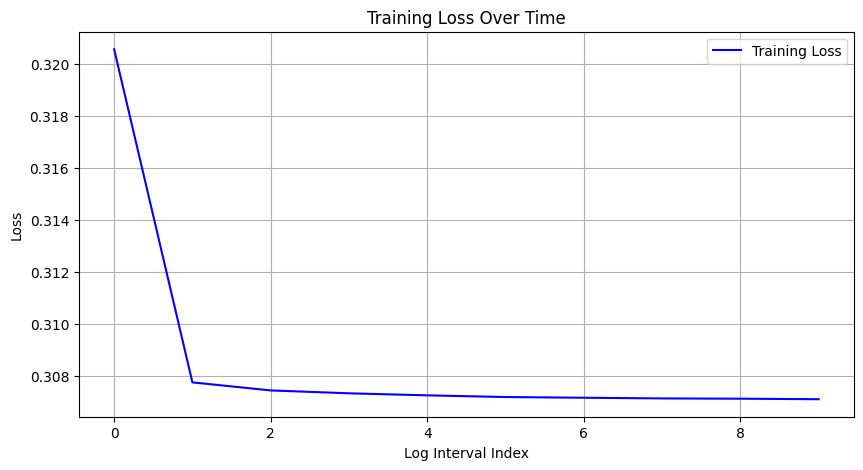

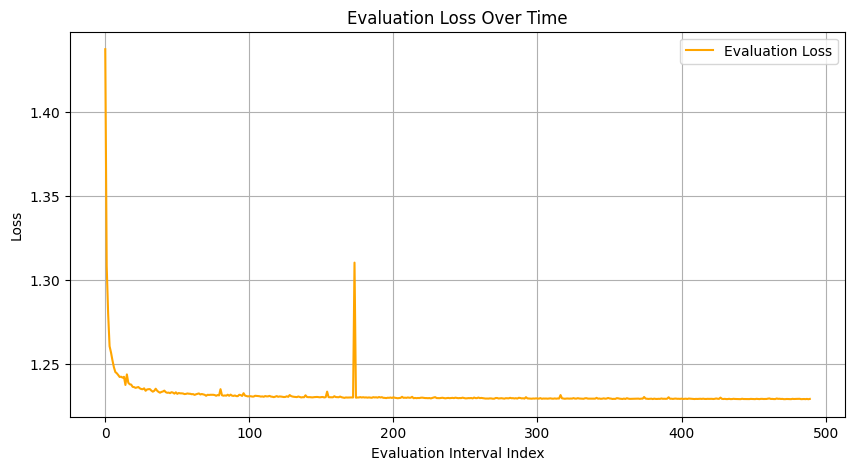

In [33]:
import matplotlib.pyplot as plt

# 1. Training Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Log Interval Index')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# 2. Evaluation Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(eval_losses, label='Evaluation Loss', color='orange')
plt.xlabel('Evaluation Interval Index')
plt.ylabel('Loss')
plt.title('Evaluation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()
